In [2]:
import numpy as np
from scipy.optimize import curve_fit
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
file = pd.read_csv('./files/times.dat', sep=r'\s+', names=['L', 'MCTOT', 'Temp', 'T'])

def func(xy, a, b, c, d, e, f):
    x, y = xy
    return a + b*x + c*y + d*x**2 + e*y**2 + f*x*y


popt, pcov = curve_fit(func, (file['L'], file['MCTOT']), file['T'])


array([ 6.31402952e+01, -3.06071489e+00, -8.82913318e-03,  2.78081184e-02,
        2.31283434e-07,  2.26054704e-04])

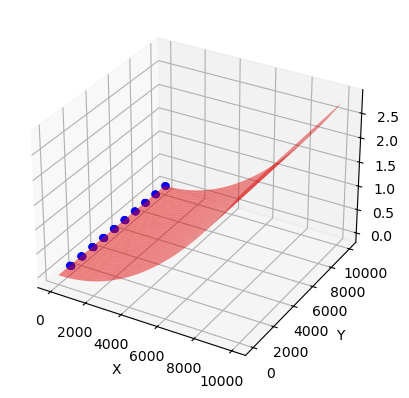

np.float64(114994.9359061495)

In [28]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(file['L'], file['MCTOT'], file['T'], color='blue')
x_range = np.linspace(0, 10000, 50)
y_range = np.linspace(0, 10000, 50)
X, Y = np.meshgrid(x_range, y_range)
Z = func((X, Y), *popt)
ax.plot_surface(X, Y, Z, color='red', alpha=0.5)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

func((2048, 10000), *popt)

### Calcul $C_v$ i $\chi$

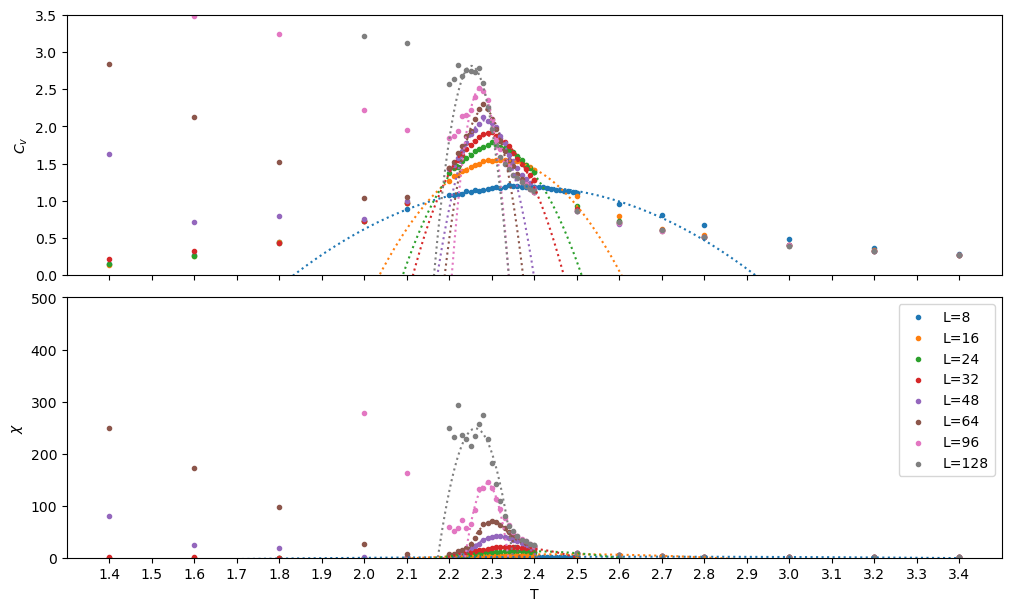

In [3]:
import warnings
warnings.filterwarnings('ignore')
df = pd.DataFrame(columns=["L", "T", "SUM", "<E>", "<E^2>", "Var E", "<M>", "<|M|>", "<M^2>", "Var M"])
dfs = []
files = [8, 16, 24, 32, 48, 64, 96, 128]
# files = [48]
for l in files:
    dfs.append(pd.read_csv(f"./files/stats-{l:3d}-2.dat", skiprows=1, sep=r'\s+', names=df.columns).sort_values("T"))

df = pd.concat(dfs, ignore_index=True)
# (($5-$4*$4)/($2*$2*$1*$1))
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10,6), layout='constrained', sharex='col')

Xfit = np.linspace(1.4, 3.4, 1000)
cv_fits = {}
chi_fits = {}
deg = 2

limits = {
    8 : (2.2, 2.4),
    16: (2.2, 2.4),
    24: (2.2, 2.4),
    32: (2.2, 2.4),
    48: (2.25, 2.33),
    64: (2.25, 2.33),
    96: (2.25, 2.3),
    128 : (2.23, 2.3),
}

for l in files:
    data = df[(df["L"] == l)]
    X = data["T"]
    Y = (data["<E^2>"]-data["<E>"]**2)/(data["T"]**2*data["L"]**2)
    (l1, l2) = limits[l]
    reduced_data = data[(df["T"] >= l1) & (df["T"] <= l2)]
    red_X = reduced_data["T"]
    red_Y = (reduced_data["<E^2>"]-reduced_data["<E>"]**2)/(reduced_data["T"]**2*reduced_data["L"]**2)
    fit = np.polynomial.Polynomial.fit(red_X, red_Y, deg=deg)
    cv_fits[l] = (fit)
    # display(data)
    ax1.plot(Xfit, fit(Xfit), linestyle=':')
    ax1.scatter(X, Y, label=f"L={l}", marker='.')

for l in files:
    data = df[(df["L"] == l)]
    X = data["T"]
    Y = (data["<M^2>"]-data["<|M|>"]**2)/(data["T"]*data["L"]**2)
    (l1, l2) = limits[l]
    reduced_data = data[(df["T"] >= l1) & (df["T"] <= l2)]
    red_X = reduced_data["T"]
    red_Y = (reduced_data["<M^2>"]-reduced_data["<|M|>"]**2)/(reduced_data["T"]*reduced_data["L"]**2)
    fit = np.polynomial.Polynomial.fit(red_X, red_Y, deg=deg)
    chi_fits[l] = (fit)
    # display(data)
    ax2.plot(Xfit, fit(Xfit), linestyle=':')
    ax2.scatter(X, Y, label=f"L={l}", marker='.')


ax2.set_xticks([x/10 for x in range(14, 35)])

# ax.set_xlim(2.2, 2.4)
ax1.set_ylim(0, 3.5)
ax2.set_ylim(0, 500)
# ax1.legend()
ax1.set_ylabel("$C_v$")
# ax1.set_xlabel("T")

ax2.legend()
ax2.set_ylabel("$\\chi$")
ax2.set_xlabel("T")

plt.show()


In [4]:
def find_extrema(poly, bounds):
    deriv = poly.deriv()
    extrema = deriv.roots()
    # Filter out complex roots
    extrema = extrema[np.isreal(extrema)]
    # Get real part of root
    extrema = np.real(extrema)
    # Apply bounds check
    lb, ub = bounds
    extrema = extrema[(lb <= extrema) & (extrema <= ub)]
    return extrema

def find_maximum(poly, bounds):
    extrema = find_extrema(poly, bounds)
    # Note: initially I tried taking the 2nd derivative to filter out local maxima.
    # This ended up being slower than just evaluating the function.

    # Either bound could end up being the minimum. Check those too.
    extrema = np.concatenate((extrema, bounds))
    # Check every candidate by evaluating the polynomial at each possible minimum,
    # and picking the minimum.
    value_at_extrema = poly(extrema)
    minimum_index = np.argmax(value_at_extrema)
    return extrema[minimum_index]


cv_maxs = {k: find_maximum(poly, (2.2, 2.5)) for k, poly in cv_fits.items()}

table = '[$L$], [$T_c$], [$C_v (T_c)$], [$chi(T_c)$], \n'
for k, t_c in cv_maxs.items():
    table += f'[{k}], [#num("{round(t_c, 3)}")], [#num("{round(cv_fits[k](t_c), 3)}")], [#num("{round(chi_fits[k](t_c), 3)}")],\n'

print(table)

[$L$], [$T_c$], [$C_v (T_c)$], [$chi(T_c)$], 
[8], [#num("2.377")], [#num("1.192")], [#num("1.558")],
[16], [#num("2.32")], [#num("1.55")], [#num("5.256")],
[24], [#num("2.301")], [#num("1.743")], [#num("10.487")],
[32], [#num("2.292")], [#num("1.876")], [#num("17.291")],
[48], [#num("2.285")], [#num("2.083")], [#num("35.816")],
[64], [#num("2.281")], [#num("2.233")], [#num("62.523")],
[96], [#num("2.273")], [#num("2.51")], [#num("129.466")],
[128], [#num("2.252")], [#num("2.813")], [#num("245.607")],



In [339]:
s = '[$L$],[$a$],[$b$],[$c$],\n'
for k, fit in cv_fits.items():
    s += f'[{k}],'
    for coef in reversed(fit.convert().coef):
        s += f'[#num("{str(round(coef, 3))}")],'
    s += '\n'

print(s)
     

[$L$],[$a$],[$b$],[$c$],
[8],[#num("-4.042")],[#num("19.214")],[#num("-21.642")],
[16],[#num("-19.111")],[#num("88.688")],[#num("-101.345")],
[24],[#num("-39.351")],[#num("181.095")],[#num("-206.608")],
[32],[#num("-59.597")],[#num("273.184")],[#num("-311.179")],
[48],[#num("-161.846")],[#num("739.774")],[#num("-843.266")],
[64],[#num("-263.022")],[#num("1200.081")],[#num("-1366.66")],
[96],[#num("-559.824")],[#num("2544.799")],[#num("-2889.471")],
[128],[#num("-363.129")],[#num("1635.58")],[#num("-1838.901")],



In [340]:
s = '[$a$],[$b$],[$c$],\n'

for k, fit in chi_fits.items():
    # s += f'[{k}],'
    for coef in reversed(fit.convert().coef):
        s += f'[#num("{str(round(coef, 3))}")],'
    s += '\n'

print(s)

[$a$],[$b$],[$c$],
[#num("-4.854")],[#num("25.797")],[#num("-32.339")],
[#num("-57.548")],[#num("284.933")],[#num("-346.049")],
[#num("-283.818")],[#num("1353.622")],[#num("-1601.496")],
[#num("-824.785")],[#num("3869.807")],[#num("-4519.487")],
[#num("-5070.599")],[#num("23518.418")],[#num("-27229.178")],
[#num("-16720.958")],[#num("76985.05")],[#num("-88542.115")],
[#num("-54838.347")],[#num("250963.184")],[#num("-286985.703")],
[#num("-31729.337")],[#num("143515.767")],[#num("-162036.478")],



### Derivades

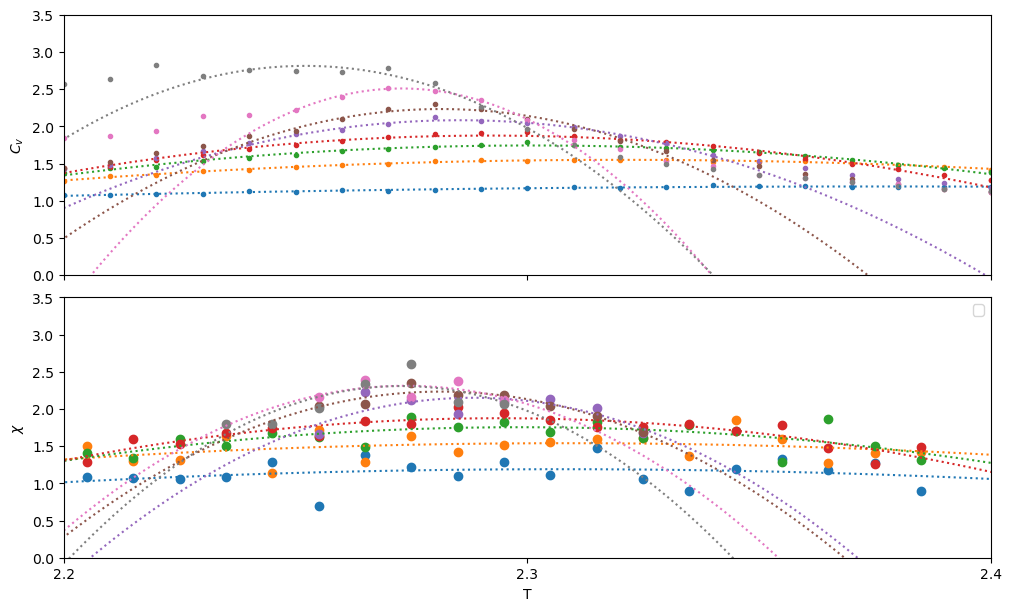

In [5]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10,6), layout='constrained', sharex='col')

for l in files:
    data = df[df["L"] == l]
    X = data["T"]
    Y = (data["<E^2>"]-data["<E>"]**2)/(data["T"]**2*data["L"]**2)
    (l1, l2) = limits[l]
    reduced_data = data[(df["T"] >= l1) & (df["T"] <= l2)]
    red_X = reduced_data["T"]
    red_Y = (reduced_data["<E^2>"]-reduced_data["<E>"]**2)/(reduced_data["T"]**2*reduced_data["L"]**2)
    fit = np.polynomial.Polynomial.fit(red_X, red_Y, deg=deg)
    cv_fits[l] = (fit)
    # display(data)
    ax1.plot(Xfit, fit(Xfit), linestyle=':')
    ax1.scatter(X, Y, label=f"L={l}", marker='.')

cv_dv_fits = {}

for l in files:
    data = df[df["L"] == l]
    (l1, l2) = limits[l]
    reduced_data = data[(df["T"] >= l1) & (df["T"] <= l2)]
    dx = np.diff(reduced_data['T'])
    X = reduced_data['T'][:-1]+dx/2
    dv = np.diff(reduced_data['<E>']/(reduced_data['L']**2))
    Y = dv/dx
    fit = np.polynomial.Polynomial.fit(X, Y, deg=deg)
    cv_dv_fits[l] = fit
    ax2.plot(Xfit, fit(Xfit), linestyle=':')
    ax2.scatter(X, Y)

ax2.set_xticks([x/10 for x in range(14, 35)])

# ax.set_xlim(2.2, 2.4)
ax1.set_ylim(0, 3.5)
ax2.set_ylim(0, 3.5)
# ax1.legend()
ax1.set_ylabel("$C_v$")
# ax1.set_xlabel("T")

ax2.legend()
ax2.set_ylabel("$\\chi$")
ax2.set_xlabel("T")
ax1.set_xlim(2.2, 2.4)

plt.show()

In [6]:

cv_dv_maxs = {k: find_maximum(poly, (2.2, 2.5)) for k, poly in cv_dv_fits.items()}

table = '[$L$], [$T_c$], [$C^"der"_v (T_c)$], \n'
for k, t_c in cv_dv_maxs.items():
    table += f'[{k}], [#num("{round(t_c, 3)}")], [#num("{round(cv_dv_fits[k](t_c), 3)}")],\n'

print(table)


[$L$], [$T_c$], [$C^"der"_v (T_c)$], 
[8], [#num("2.307")], [#num("1.19")],
[16], [#num("2.308")], [#num("1.54")],
[24], [#num("2.299")], [#num("1.755")],
[32], [#num("2.294")], [#num("1.876")],
[48], [#num("2.289")], [#num("2.151")],
[64], [#num("2.281")], [#num("2.234")],
[96], [#num("2.274")], [#num("2.312")],
[128], [#num("2.273")], [#num("2.309")],



,x,y
7,0.007812,2.261563
6,0.010417,2.288209
5,0.015625,2.302053
4,0.020833,2.319097
3,0.031250,2.345950
2,0.041667,2.384666
1,0.062500,2.475609
0,0.125000,2.500000


2.25219323 + 1.42685653·x
2.24630446 + 3.32050154·x


[np.float64(2.246304462578328), np.float64(2.2521932308848553)]

2.2492488467315916 +- 0.0029443841532637016


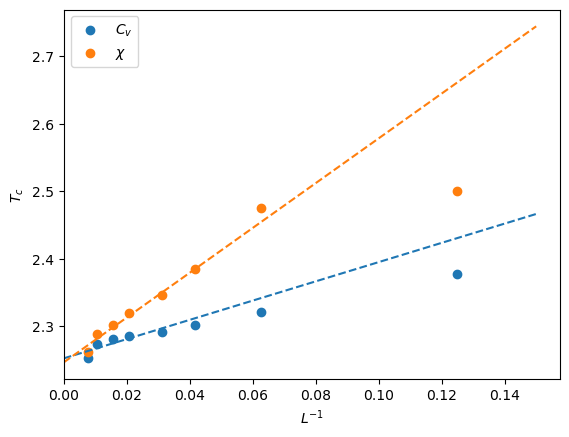

In [7]:
inverse_ls = [1/k for k in files]
chi_maxs = {l: find_maximum(chi_fits[l], (2.2, 2.5)) for l in files}
cv_inv = pd.DataFrame({"x": inverse_ls, "y": cv_maxs.values()}).sort_values('x')
chi_inv = pd.DataFrame({"x": inverse_ls, "y": chi_maxs.values()}).sort_values('x')
deg = 1
display(chi_inv)
red_cv = cv_inv[ (cv_inv['x'] < 0.04)]
red_chi = chi_inv[(chi_inv['x'] < 0.05)]
polyfit_cv = np.polynomial.Polynomial.fit(red_cv['x'], red_cv['y'], deg=deg)
polyfit_chi = np.polynomial.Polynomial.fit(red_chi['x'], red_chi['y'], deg=deg)
polyfit_x = np.linspace(0, 0.15, 100) 
fig, ax = plt.subplots()
ax.scatter(cv_inv['x'], cv_inv['y'], label='$C_v$')
ax.plot(polyfit_x, polyfit_cv(polyfit_x), linestyle='--')
ax.scatter(chi_inv['x'], chi_inv['y'], label='$\\chi$')
ax.plot(polyfit_x, polyfit_chi(polyfit_x), linestyle='--')
ax.set_xlabel("$L^{-1}$")
ax.set_ylabel("$T_c$")
ax.set_xlim(0)
ax.legend()

print(polyfit_cv.convert())
print(polyfit_chi.convert())
bs = [polyfit_chi.convert().coef[0], polyfit_cv.convert().coef[0]]
display(bs)
print(f"{np.average(bs)} +- {np.std(bs)}")
plt.show()


-3.04313652 + 1.75475745·x


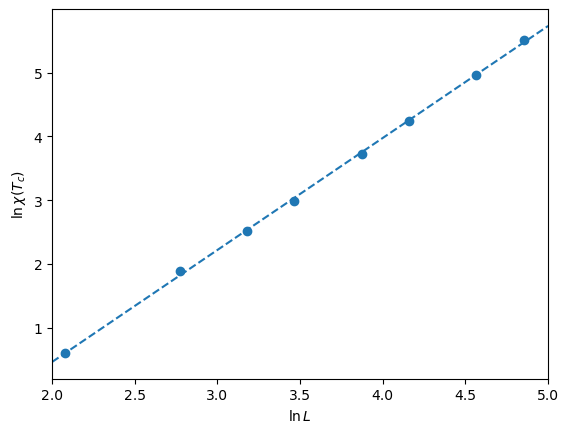

gamma = 1.7547574489866153 +/- 0.01756369737945237


In [8]:
chi_tc = [chi_fits[k](chi_maxs[k]) for k in files]

chis_gamma = pd.DataFrame({'x': np.log(files), 'y': np.log(chi_tc)})

fig, ax = plt.subplots()
gamma_fit = np.polynomial.Polynomial.fit(chis_gamma['x'], chis_gamma['y'], deg=1)
x_fit = np.linspace(2, 5, 100)
ax.scatter(chis_gamma['x'], chis_gamma['y'])
ax.plot(x_fit, gamma_fit(x_fit), linestyle='--')
ax.set_xlim(2, 5)
ax.set_xlabel("$\\ln{L}$")
ax.set_ylabel("$\\ln{\\chi(T_c)}$")

print(gamma_fit.convert())

plt.show()
coeffs, cov = np.polyfit(chis_gamma['x'], chis_gamma['y'], deg=1, cov=True)
m, b = coeffs                # pendiente y ordenada
sigma_m = np.sqrt(cov[0,0])  # incertidumbre de la pendiente
sigma_b = np.sqrt(cov[1,1])  # incertidumbre de la ordenada

print("gamma =", m, "+/-", sigma_m)

-0.04183121 + 0.09059034·x


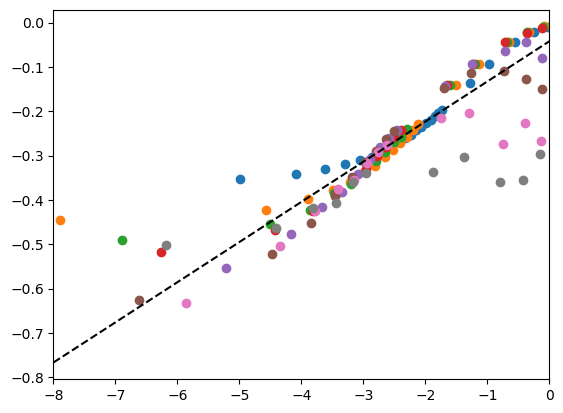

gamma = 0.0905903439556221 +/- 0.010364322453665736


In [9]:
agg = pd.DataFrame(columns=['x', 'y'])
fig, ax = plt.subplots()
for l in files:
    data = df[(df['L'] == l) & (df['T'] < cv_maxs[l])]
    Ys = np.log(data['<|M|>']/data['L']**2)
    Xs = np.log(cv_maxs[l] - data['T'])
    reduced_data = pd.DataFrame({'x': Xs, 'y': Ys})
    reduced_data = reduced_data[(reduced_data['x'] < -2) & (reduced_data['x'] > -2.8)]
    agg = pd.concat([agg, reduced_data], ignore_index=True)
    ax.scatter(Xs, Ys)
agg = agg.sort_values('x')
beta_fit = np.polynomial.Polynomial.fit(agg['x'], agg['y'], deg=1)
x_fit = np.linspace(-8, 0, 100)
ax.set_xlim(-8, 0)
ax.plot(x_fit, beta_fit(x_fit), linestyle='--', color='black')

print(beta_fit.convert())
plt.show()

coeffs, cov = np.polyfit(agg['x'], agg['y'], deg=1, cov=True)
m, b = coeffs                # pendiente y ordenada
sigma_m = np.sqrt(cov[0,0])  # incertidumbre de la pendiente
sigma_b = np.sqrt(cov[1,1])  # incertidumbre de la ordenada

print("gamma =", m, "+/-", sigma_m)
